#Stock Price Prediction using seq2seq model in PyTorch
Stock price information is a type of time-series data. Both neural and non-neural approaches are helpful for analyzing that kind of data. The approaches for modeling the time-series data are also known as **Sequence Modeling** techniques.

In this code, we use **Encoder-Decoder** model, also known as **seq2seq**, for modeling the stock price. Thus, we can predict the stock price for the future.

#YOUR_JOB

Please complete the code denoted by **#YOUR_JOB** according to the comments.

In [ ]:
import numpy as np                          
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from time import time
import math
from sklearn.metrics import mean_squared_error

# 1. Data
We import the dataset using pandas package.

#YOUR_JOB

Read the stock datasets, named `AMZN_2006-01-01_to_2018-01-01.csv`. Don't forget to upload it to the colab machine first. Note that the dataset is one of the stock data from [**kaggle DJIA 30 Stock Time Series**](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231).

In [ ]:
print("Getting data ...")

data = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv")
print("Data is ready.")

data.head()

Getting data ...
Data is ready.


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


#### 1.1. Plots
The raw dataset contains `Date`, `Open`, `High`, `Low`, `Close`, `Volume`, and `Name`. We use the close value for the modeling task. We plot the closing price and its autocorrelation here.

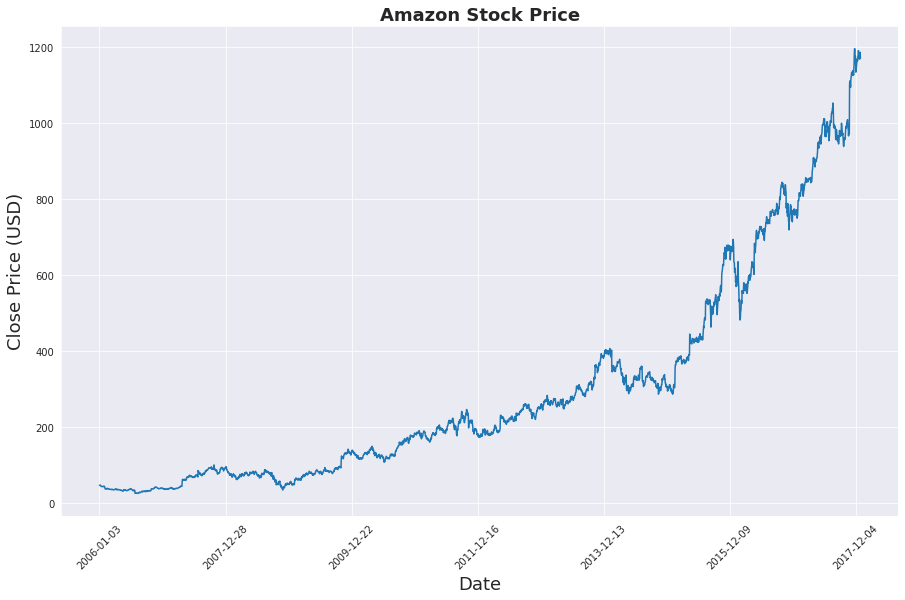

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

#### 1.2 Preprocessing

In [ ]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 1.3. Split Data

To make the input and output sequences, we slide a window of the length `lookback` on the data. Using the sliding window, the stock price data (`shape: L x 1`) will be converted to `N` samples of the shape `lookback x 1`. 

Now, of every sample (with the length of `lookback`), we keep `x_seq_len` data points for the input `x` and the rest for the output `y`. 

Note that in the seq2seq model, `T_x` is not necessarily equal to `T_y`, meaning that the input and output does not necessarily have the same length. 

**#YOUR_JOB**


Try to complete the `split_data` function in the following cell. After converting the stock price sequence to `N` samples of the length `lookback`, we would like to keep `train_set_size` samples for the training set and the rest for the test set. Moreover, the first `T_x` data points make the input and the rest are supposed to be seen in the output. 

In [ ]:
def split_data(stock, lookback, x_seq_len):
    y_seq_len = lookback - x_seq_len
    data_raw = stock.to_numpy() # convert to numpy array; [L x 1]
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)                               # [N x lookback x 1]
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size, : -y_seq_len, :]    # [N_train x T_x x 1]
    y_train = data[:train_set_size, x_seq_len :, :]     # [N_train x T_y x 1]
    
    x_test = #------- YOUR CODE HERE --------
    y_test = #------- YOUR CODE HERE --------
    
    return [x_train, y_train, x_test, y_test]

In the following cell, we make input and output sequences from the only sequence of the stock price history.

`lookback` is the sweeping window length, in which both input and output sequences come out. Every `x_seq_len` samples are used to predict `lookback - x_seq_len` samples in the output. 


In [ ]:
lookback = 20  
x_seq_len = 15 
x_train, y_train, x_test, y_test = split_data(price, lookback, x_seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2399, 15, 1)
y_train.shape =  (2399, 5, 1)
x_test.shape =  (600, 15, 1)
y_test.shape =  (600, 5, 1)


# 2. Model

We would like to make a seq2seq model. We define three classes for: 
* Encoder
* Decoder
* seq2seq

#### 2.1. Hyper-parameters

In [ ]:
input_dim = 1
enc_hidden_dim = 32
dec_hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 100

# specify GPU
device = torch.device("cuda")

#### 2.2. Encoder Class

In the following cells, we create the **Encoder** and **Decoder** classes. Then we define our seq2seq model. 

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.LSTM(input_dim, 
                           hid_dim, 
                           n_layers, 
                           dropout=dropout, 
                           batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
                                        # x: [N, T_x, 1]
        outputs, (hidden, cell) = self.rnn(x)
                                        # outputs: [N, T_x, D*n_dir]
                                        # hidden:  [n_layers*n_dir, N, D]
                                        # cell:    [n_layers*n_dir, N, D]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

#### 2.3. Decoder Class

The decoder class is defined in the following cell. The output of the last timestep in the encoder is fed to the decoder. The final predicted output is the activation of a fully connected layer on top of the decoder. Please note that `n_dir` and `seq_len` in decoder are always 1, meaning that the decoder is always unidirectional and the `forward` function is called once in every decoder time-step.

**#YOUR_JOB**
To make the output prediction in every decoder time-step, we employ the output of the RNN. A linear layer (output layer) is needed to convert the **D-dimensional** output of the RNN to **1-dimensional** predicted value for the stock price. Please complete the following code for the output layer. Don't forget to check the dimensions.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(output_dim, 
                           hid_dim, 
                           n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        # print("decoder input shape: %s" % str(input.shape))
        
                                        # input:      [N, 1]
        input = input.unsqueeze(1)
        # print("decoder rnn input shape: %s" % str(input.shape))
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
                                        # hidden:     [n_layers, N, D]
                                        # cell:       [n_layers, N, D]
                                        # output:     [N, 1, D]
        
        prediction = #------- YOUR CODE HERE --------
                                        # prediction: [N, 1]
        
        # print("decoder prediction shape: %s" % str(prediction.shape))

        return prediction, hidden, cell

#### 2.4. seq2seq Class

The seq2seq class connects both encoder and decoder models. Note that the last hidden state of the encoder is used as the initial hidden state of the decoder. Also, first input to the decoder is the `<Go>` tokens.



In the decoder, `teacher_forcing_ratio` is probability to use teacher forcing; e.g. if `teacher_forcing_ratio = 0.75`, we use ground-truth inputs 75% of the time.


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        # TODO: There should be a better way to check the compatibility
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src: [N, T_x, 1]
        # trg: [N, T_y, 1]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_dim = trg.shape[2]
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_dim).to(self.device)
        
        hidden, cell = self.encoder(src)
        # print("encoder hidden shape: %s" % str(hidden.shape))
                                        # hidden:  [n_layers*n_dir, N, D]
                                        # cell:    [n_layers*n_dir, N, D]


        # <Go> token
        input = torch.zeros(batch_size, trg_dim).to(device)
       
        for t in range(trg_len):
            
            # print("seq2seq input shape: %s" % str(input.shape))


            # insert input, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
                                                     # output: [N, 1] 
            # print("seq2seq dec output shape: %s" % str(output.shape))

            outputs[t] = output                      # outputs: [T_y, N, 1]
            
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.random() < teacher_forcing_ratio
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[:, t, :].view(batch_size, 1) if teacher_force else output
        
        return outputs.permute(1, 0, 2)

#### 2.5. Model Definition

In [ ]:
enc = Encoder(input_dim, enc_hidden_dim, num_layers, output_dim)
dec = Decoder(input_dim, dec_hidden_dim, num_layers, output_dim) 
model = Seq2Seq(enc, dec, device)
print(model)



# push the model to GPU
model = model.to(device)

criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(1, 32, batch_first=True, dropout=1.0)
    (dropout): Dropout(p=1, inplace=False)
  )
  (decoder): Decoder(
    (rnn): LSTM(1, 32, batch_first=True, dropout=1.0)
    (fc_out): Linear(in_features=32, out_features=1, bias=True)
    (dropout): Dropout(p=1, inplace=False)
  )
)


# 3. Train


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,993 trainable parameters


In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#### 3.1. Main Train Loop

In [ ]:
hist = np.zeros(num_epochs)
start_time = time()

for t in range(num_epochs):
    y_train_pred = model(x_train.to(device), y_train.to(device))

    loss = criterion(y_train_pred, y_train.to(device))
    print("Epoch ", t, "MSE: ", loss.item(), 
          " pred_sample: ", y_train_pred[0, 0, 0].cpu().detach().numpy(),
          "sample: ", y_train[0, 0, 0].numpy())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time() - start_time
print("Training time: {} min".format(training_time / 60))

Epoch  0 MSE:  0.7893337607383728  pred_sample:  0.061262697 sample:  -0.97002804
Epoch  1 MSE:  0.6013858318328857  pred_sample:  -0.07540647 sample:  -0.97002804
Epoch  2 MSE:  0.4023529887199402  pred_sample:  -0.24834968 sample:  -0.97002804
Epoch  3 MSE:  0.1936241239309311  pred_sample:  -0.5080936 sample:  -0.97002804
Epoch  4 MSE:  0.03941887244582176  pred_sample:  -0.89259565 sample:  -0.97002804
Epoch  5 MSE:  0.21327121555805206  pred_sample:  -1.259899 sample:  -0.97002804
Epoch  6 MSE:  0.15315401554107666  pred_sample:  -1.1691781 sample:  -0.97002804
Epoch  7 MSE:  0.05784647911787033  pred_sample:  -0.99027795 sample:  -0.97002804
Epoch  8 MSE:  0.033963900059461594  pred_sample:  -0.81970394 sample:  -0.97002804
Epoch  9 MSE:  0.05034082382917404  pred_sample:  -0.6942108 sample:  -0.97002804
Epoch  10 MSE:  0.06652236729860306  pred_sample:  -0.6185137 sample:  -0.97002804
Epoch  11 MSE:  0.07492516189813614  pred_sample:  -0.5819484 sample:  -0.97002804
Epoch  12 MS

#### 3.2. Plots

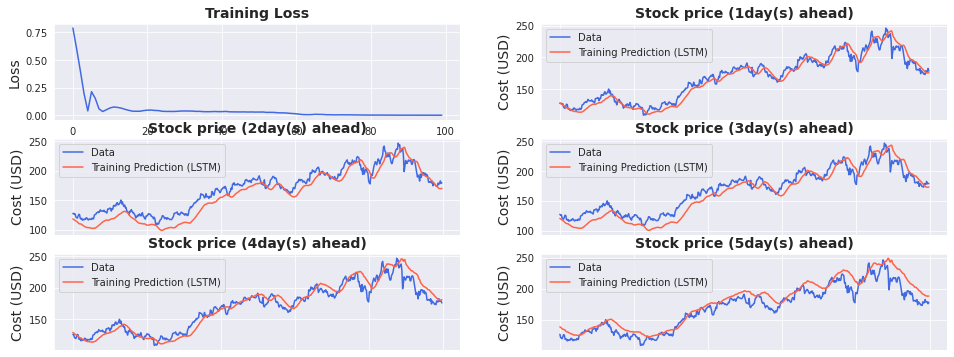

In [ ]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

begin_idx = 1000
end_idx = 1500

plt.subplot(3, 2, 1)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

for i in range(y_train.shape[1]):
  plt.subplot(3, 2, i+2)

  predict = pd.DataFrame(scaler.inverse_transform(y_train_pred[begin_idx:end_idx, i, :].view(-1, 1).cpu().detach().numpy()))
  original = pd.DataFrame(scaler.inverse_transform(y_train[begin_idx:end_idx, i, :].view(-1, 1).numpy()))

  ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
  ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
  title = 'Stock price (' + str(i+1) + 'day(s) ahead)'
  ax.set_title(title, size = 14, fontweight='bold')
  ax.set_ylabel("Cost (USD)", size = 14)
  ax.set_xticklabels('', size=10)

# 4. Evaluation

#### 4.1. MSE


In [ ]:
# make predictions
y_test_pred = model(x_test.to(device), y_test.to(device))

train_rmse = list()
test_rmse = list()

for i in range(y_train.shape[1]):
  # invert predictions
  y_train_pred_ = scaler.inverse_transform(y_train_pred[:, i, :].view(-1, 1).cpu().detach().numpy())
  y_train_ = scaler.inverse_transform(y_train[:, i, :].view(-1, 1).numpy())
  y_test_pred_ = scaler.inverse_transform(y_test_pred[:, i, :].view(-1, 1).cpu().detach().numpy())
  y_test_ = scaler.inverse_transform(y_test[:, i, :].view(-1, 1).numpy())

  # calculate root mean squared error
  train_rmse.append(math.sqrt(mean_squared_error(y_train_[:,0], y_train_pred_[:,0])))
  test_rmse.append(math.sqrt(mean_squared_error(y_test_[:,0], y_test_pred_[:,0])))

train_errors = pd.DataFrame(np.array(train_rmse))
test_errors = pd.DataFrame(np.array(test_rmse))
print('Train Scores (RMSE):')
print(train_errors)
print()
print('Test Scores (RMSE):')
print(test_errors)


Train Scores (RMSE):
           0
0  11.443623
1  15.106546
2  15.807851
3  13.781311
4  16.328491

Test Scores (RMSE):
            0
0  277.400447
1  304.996286
2  326.257759
3  347.288616
4  326.597731
